## Age and Gender Detection System.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [ ]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the dataset

In [ ]:
!unzip '/content/drive/MyDrive/Gender Age/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
# Setting the Directory
import os
directory = '/content/UTKFace'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# With the Help of Cv2 tried reading a image
import cv2
image_path = "35_1_0_20170105162344803.jpg"
image = cv2.imread(image_path)

In [ ]:
BASE_DIR = '/content/UTKFace'  # sets the base directory path where the face images are located.
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir('/content/UTKFace')
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [ ]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/49_0_3_20170119202423862.jpg....,49,0
1,/content/UTKFace/25_1_0_20170116002343174.jpg....,25,1
2,/content/UTKFace/70_1_0_20170110181712528.jpg....,70,1
3,/content/UTKFace/25_1_1_20170117170628763.jpg....,25,1
4,/content/UTKFace/50_0_0_20170111201507166.jpg....,50,0


## Exploratory Data Anlysis

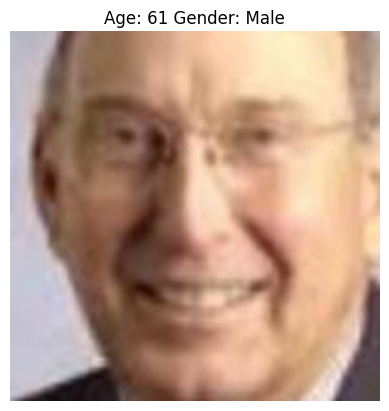

In [ ]:
from PIL import Image

rand_index = random.randint(0, len(image_paths)) # generates a random index within the range of available image paths
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index]) # open an image corresponding to the randomly selected index from the DataFrame
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

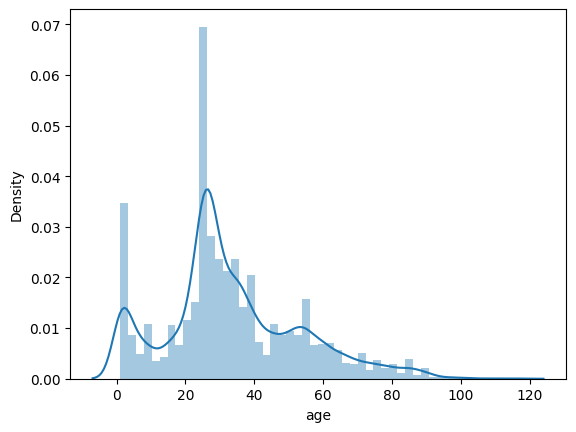

In [ ]:
 # Age distribution
 sns.distplot(df['age'])

The distribution roughly follows a normal distribution that is slightly skewed to the right with a median of around 27 years. The range is from 0 to 120 years. There are some outliers at the higher end of the distribution.

<Axes: ylabel='count'>

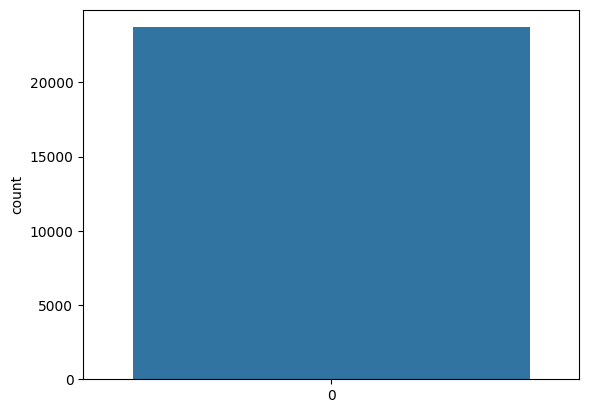

In [ ]:
sns.countplot(df['gender'])

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

In [ ]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

## Feature Extraction

In [ ]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X / 255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
# CNN Model
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

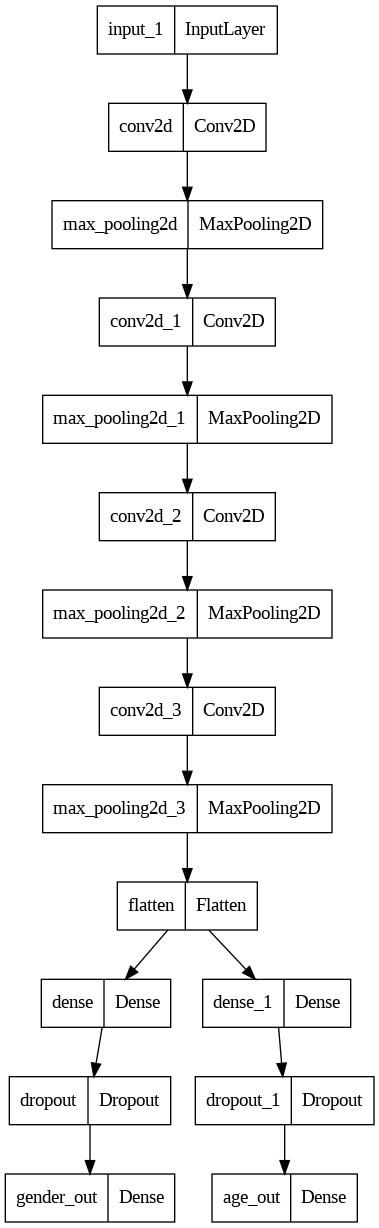

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

# fit method is used to train a model on a given dataset.
# 20% of the training data will be used for validation, helping to monitor the model's performance on unseen data.

Epoch 1/50
593/593 [==============================] - 26s 23ms/step - loss: 15.1455 - gender_out_loss: 0.6509 - age_out_loss: 14.4945 - gender_out_accuracy: 0.5930 - age_out_accuracy: 0.0466 - val_loss: 11.5705 - val_gender_out_loss: 0.5009 - val_age_out_loss: 11.0695 - val_gender_out_accuracy: 0.7512 - val_age_out_accuracy: 0.0380
Epoch 2/50
593/593 [==============================] - 11s 19ms/step - loss: 11.0574 - gender_out_loss: 0.4709 - age_out_loss: 10.5865 - gender_out_accuracy: 0.7778 - age_out_accuracy: 0.0271 - val_loss: 10.0330 - val_gender_out_loss: 0.4160 - val_age_out_loss: 9.6170 - val_gender_out_accuracy: 0.8041 - val_age_out_accuracy: 0.0097
Epoch 3/50
593/593 [==============================] - 12s 19ms/step - loss: 9.4216 - gender_out_loss: 0.3995 - age_out_loss: 9.0221 - gender_out_accuracy: 0.8168 - age_out_accuracy: 0.0151 - val_loss: 9.5918 - val_gender_out_loss: 0.3655 - val_age_out_loss: 9.2263 - val_gender_out_accuracy: 0.8296 - val_age_out_accuracy: 0.0074
Epo


## Plot Results

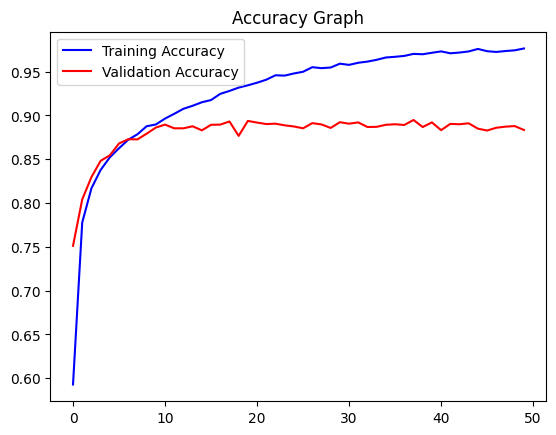

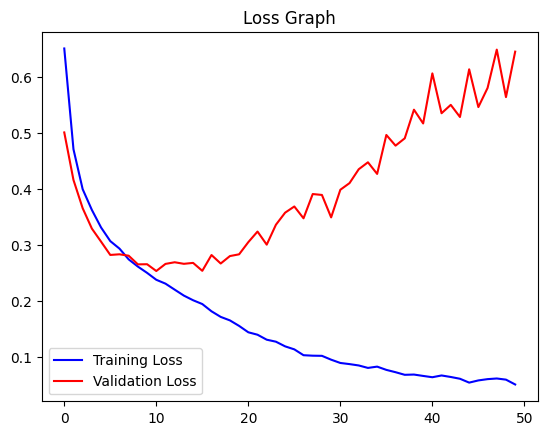

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

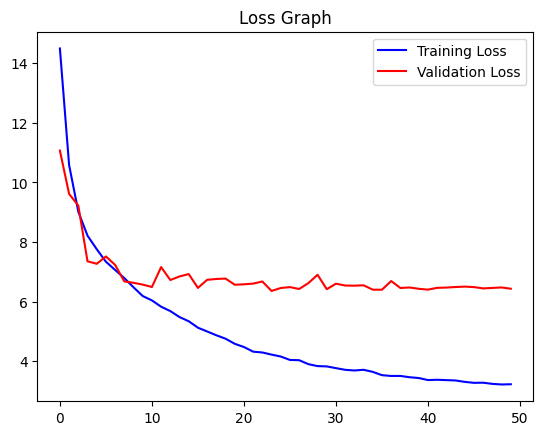

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Predicting Test Data

In [ ]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 269ms/step


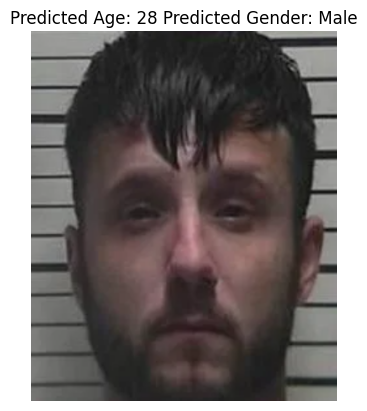

In [ ]:
img_to_test = '/content/drive/MyDrive/Gender Age/test images/3.png'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
from PIL import Image

# Define the predict function
def predict_image(image):
    # Preprocess the input image
    input_image = Image.open(input_image.name)
    input_image = np.array(input_image)

    # Perform inference using your model
    prediction = model.predict(input_image)

    # Assuming the prediction is a dictionary with 'age' and 'gender' keys
    age = prediction['Age']
    gender = prediction['Gender']

    return f"Predicted Age: {age}, Predicted Gender: {gender}"

# Define the Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.inputs.Image(),
    outputs="text",
    title="Age and Gender Detection",
    description="Upload an image and the model will predict the age and gender.",
    live=True
)

# Launch the interface
iface.launch()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>